# **<font color=white> 05.Hierarchical Clustering Code 실습**

[목적]
  - 비지도학습 중 하나인 Clustering 중 Hierarchical Clustering 실습
  - 덴드로그램을 그려 Cluster 결정
  - Clustering은 기본적으로 Data가 많을 때 시간이 굉장히 오래걸림
     - Distance Matrix를 만들고 행렬 계산을 하는 알고리즘이 많기 때문

[Process]
  1. Define X's
  2. Modeling

In [1]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Data Loading (수술 時 사망 데이터)
data=pd.read_csv("https://raw.githubusercontent.com/GonieAhn/Data-Science-online-course-from-gonie/main/Data%20Store/example_data.csv")

In [3]:
# Data Checking
col = []
missing = []
level = [] 
for name in data.columns:
    
    # Missing
    missper = data[name].isnull().sum() / data.shape[0]
    missing.append(round(missper, 4))

    # Leveling
    lel = data[name].dropna()
    level.append(len(list(set(lel))))

    # Columns
    col.append(name)

summary = pd.concat([pd.DataFrame(col, columns=['name']), 
                     pd.DataFrame(missing, columns=['Missing Percentage']), 
                     pd.DataFrame(level, columns=['Level'])], axis=1)


In [4]:
drop_col = summary['name'][(summary['Level'] <= 1) | (summary['Missing Percentage'] >= 0.8)]
data.drop(columns=drop_col, inplace=True)
print(">>>> Data Shape : {}".format(data.shape))

>>>> Data Shape : (532, 22)


In [5]:
drop_col

10    zprior
Name: name, dtype: object

In [6]:
summary

,name,Missing Percentage,Level
0,censor,0.0,2
1,event,0.0,358
2,age,0.0,52
3,wtkg,0.0,312
4,hemo,0.0,2
5,homo,0.0,2
6,drugs,0.0,2
7,karnof,0.0,4
8,oprior,0.0,2
9,z30,0.0,2


In [7]:
# X's & Y Split
Y = data['censor']
X = data.drop(columns=['censor'])

In [8]:
X

,event,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,preanti,...,gender,str2,strat,symptom,cd40,cd420,cd496,r,cd80,cd820
0,1090,43,66.679,0,1,0,100,0,1,1352,...,1,1,3,0,504,353,660,1,870,782
1,794,31,73.030,0,1,0,100,0,1,930,...,1,1,3,0,244,225,106,1,708,699
2,957,41,66.226,0,1,1,100,0,1,1329,...,1,1,3,0,401,366,453,1,889,720
3,188,35,78.019,0,1,0,100,0,1,964,...,1,1,3,0,221,132,-1,0,221,759
4,308,40,83.009,0,1,0,100,0,1,974,...,1,1,3,1,150,90,20,1,1730,1160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,1097,24,71.000,1,0,0,100,0,1,334,...,1,1,2,0,364,475,734,1,770,802
528,154,21,52.300,1,0,0,90,0,1,24,...,1,1,2,0,415,181,84,1,949,666
529,588,16,63.000,1,0,0,100,0,1,753,...,1,1,3,0,299,214,124,1,546,471
530,395,17,102.967,1,0,0,100,0,1,417,...,1,1,3,0,373,218,-1,0,1759,1030


[Clustering 전 Scaling]

  - Clustering은 Distance를 구하는 작업이 필요함
  - Feature들의 Scale이 다르면 Distance를 구하는데 가중치가 들어가게 됨
  - 따라서, Distance 기반의 Clustering의 경우 Scaling이 필수

In [9]:
# Scaling
scaler = MinMaxScaler().fit(X)
X_scal = scaler.transform(X)
X_scal = pd.DataFrame(X_scal, columns=X.columns)

In [10]:
X_scal

,event,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,preanti,...,gender,str2,strat,symptom,cd40,cd420,cd496,r,cd80,cd820
0,0.882304,0.526316,0.189746,0.0,1.0,0.0,1.000000,0.0,1.0,0.543190,...,1.0,1.0,1.0,0.0,0.600299,0.353488,0.770396,1.0,0.160882,0.212081
1,0.635225,0.315789,0.252256,0.0,1.0,0.0,1.000000,0.0,1.0,0.373644,...,1.0,1.0,1.0,0.0,0.211078,0.204651,0.124709,1.0,0.120724,0.184228
2,0.771285,0.491228,0.185287,0.0,1.0,1.0,1.000000,0.0,1.0,0.533949,...,1.0,1.0,1.0,0.0,0.446108,0.368605,0.529138,1.0,0.165592,0.191275
3,0.129382,0.385965,0.301361,0.0,1.0,0.0,1.000000,0.0,1.0,0.387304,...,1.0,1.0,1.0,0.0,0.176647,0.096512,0.000000,0.0,0.000000,0.204362
4,0.229549,0.473684,0.350476,0.0,1.0,0.0,1.000000,0.0,1.0,0.391322,...,1.0,1.0,1.0,1.0,0.070359,0.047674,0.024476,1.0,0.374070,0.338926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,0.888147,0.192982,0.232276,1.0,0.0,0.0,1.000000,0.0,1.0,0.134190,...,1.0,1.0,0.5,0.0,0.390719,0.495349,0.856643,1.0,0.136093,0.218792
528,0.101002,0.140351,0.048219,1.0,0.0,0.0,0.666667,0.0,1.0,0.009642,...,1.0,1.0,0.5,0.0,0.467066,0.153488,0.099068,1.0,0.180466,0.173154
529,0.463272,0.052632,0.153535,1.0,0.0,0.0,1.000000,0.0,1.0,0.302531,...,1.0,1.0,1.0,0.0,0.293413,0.191860,0.145688,1.0,0.080565,0.107718
530,0.302170,0.070175,0.546915,1.0,0.0,0.0,1.000000,0.0,1.0,0.167537,...,1.0,1.0,1.0,0.0,0.404192,0.196512,0.000000,0.0,0.381259,0.295302


[Hierarchical Clustering]
  - Package : https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
  - Package : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
  - method
    - 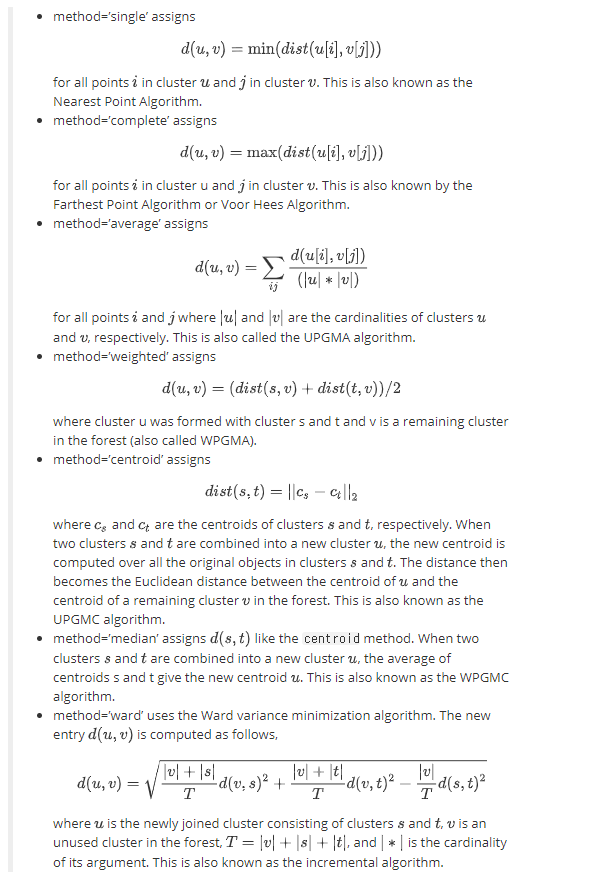
    - Ward : 와드연결법(Ward linkage)은 군집간의 거리에 따라 데이터들을 연결하기 보다는 군집내 편차들의 제곱합(within group sum of squares)에 근거를 두고 군집들을 병합시키는 방법
    - metric : 거리 계산법

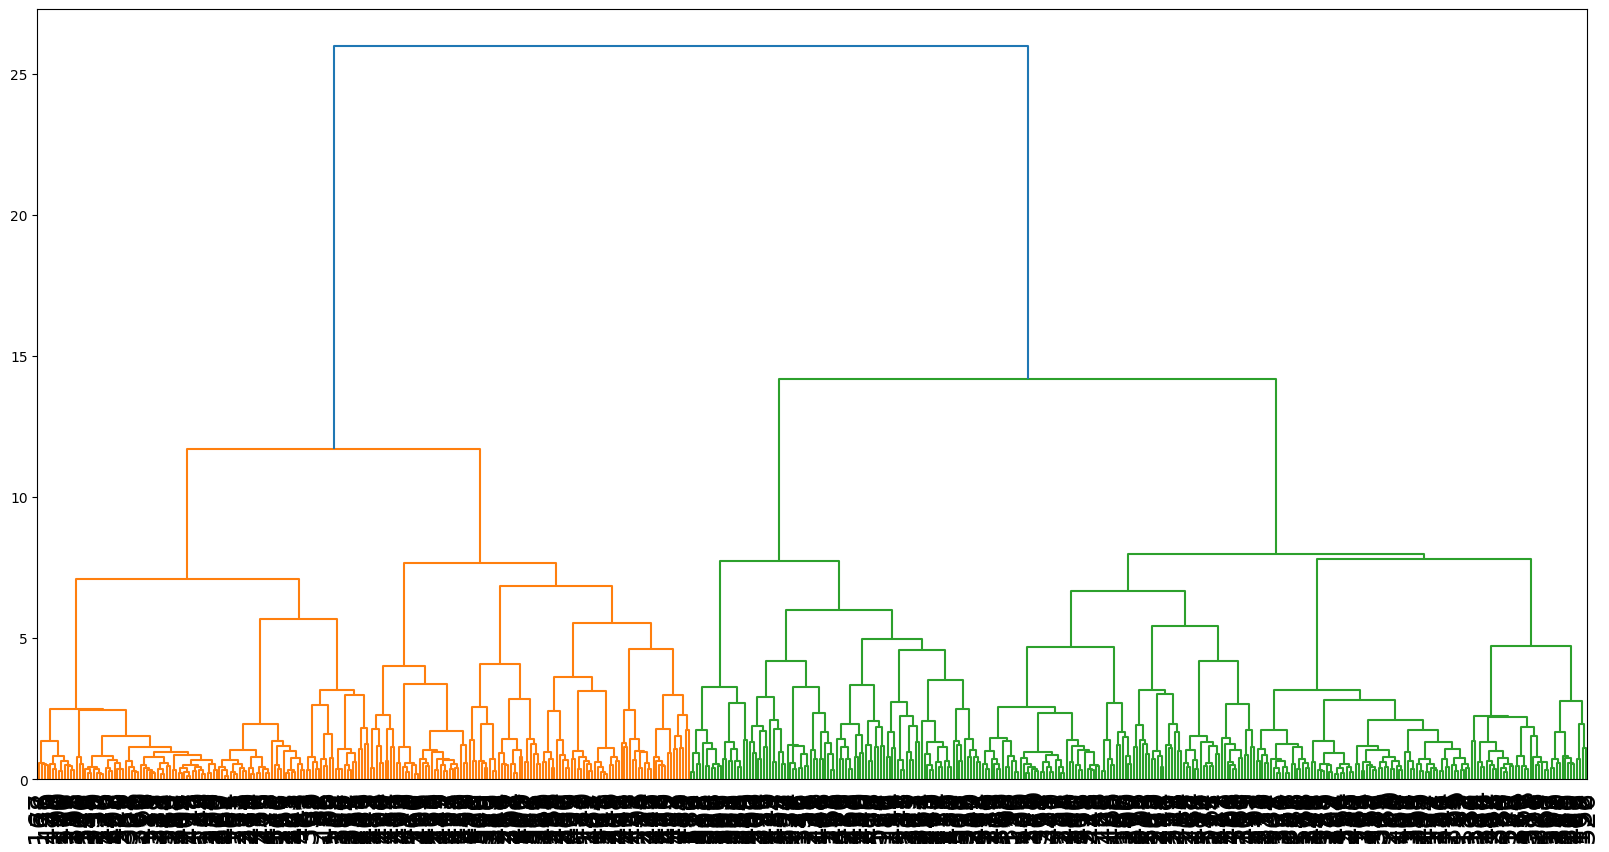

In [11]:
# Set up HC

meth = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']

HC = linkage(X_scal,method=meth[-1])
plt.figure(figsize=(20,10))
dendrogram(HC,
            leaf_rotation=90,
            leaf_font_size=20)
plt.show()